In [ ]:
# ===========================
# Investigating the Removal of Cadmium from Water through UiO-66 Derivatives using Molecular Dynamics
# =========================== 

# 📊 Radial Distribution Function Plots
# ---------------------------
# Table of Contents
# 1️⃣ Radial Distribution Function Cd-MOF 
# 2️⃣ Radial Distribution Function Water-MOF 
# ----------------------------

Read cached data for cd100_uio66-COO2_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO3_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO4_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO_merged_rep_rdf-box.txt
Total time for data processing/loading: 3.01 seconds


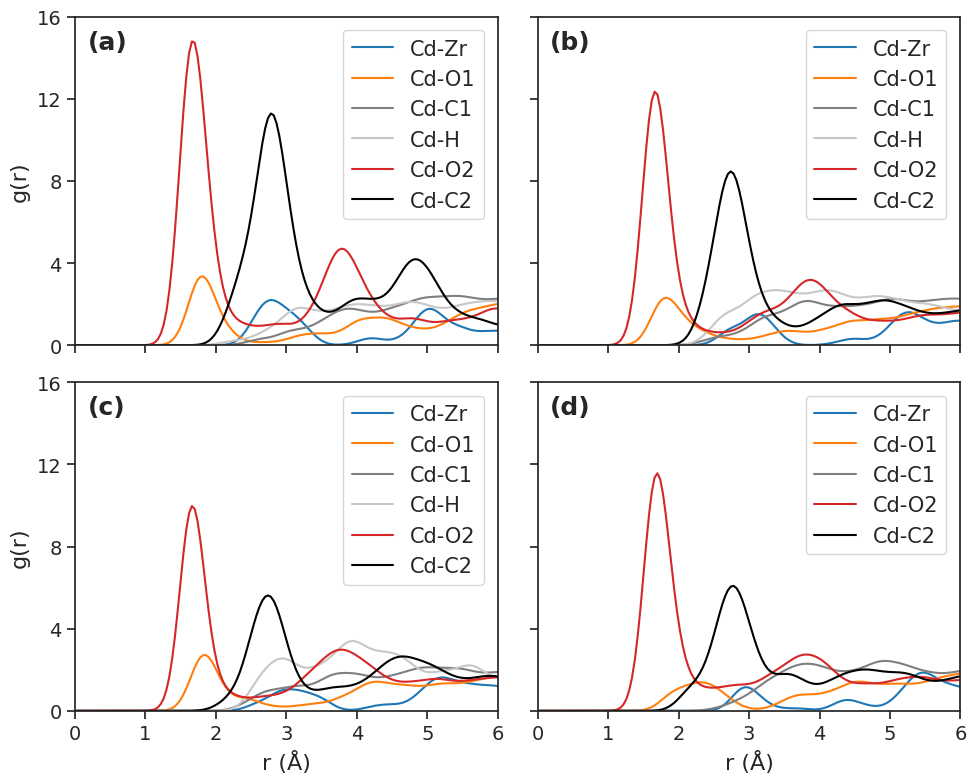

Total execution time: 3.84 seconds


In [1]:
# ============================
# 1️⃣ Radial Distribution Function Cd-MOF 
# =========================== 
# 📅 Date Created: Sept 23, 2024

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import glob
import os
import time
import matplotlib.ticker as ticker

def read_or_process_rdf_data(cd_value, cache_dir):
    start_time = time.time()
    os.makedirs(cache_dir, exist_ok=True)
    
    files = glob.glob(f'cd{cd_value}_uio66-COO*_merged_rep_rdf-box.txt')
    dfs = {}
    
    for file in files:
        base_name = os.path.basename(file)
        csv_file = os.path.join(cache_dir, f'{base_name}_last_frame.csv')
        
        if os.path.exists(csv_file):
            # Read from cache if it exists
            df = pd.read_csv(csv_file)
            dfs[base_name] = df
            print(f"Read cached data for {base_name}")
        else:
            # Process the file and save to cache
            print(f"Processing {base_name}")
            with open(file, 'r') as f:
                lines = f.readlines()
            data = []
            frame_title = None
            num_bins = None
            last_frame_data = []
            for line in lines:
                if line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) == 2:
                    if last_frame_data:
                        data = last_frame_data
                    last_frame_data = []
                    frame_title = int(parts[0])
                    num_bins = int(parts[1])
                else:
                    bin_number = int(parts[0])
                    values = list(map(float, parts[1:]))
                    last_frame_data.append([frame_title, bin_number] + values)
            
            # Use the last frame data
            data = last_frame_data
            
            if 'COO4' in file:
                columns = ['Frame Title', 'Bin Number'] + [f'c_boxrdf[{i}]' for i in range(1, 16)]
            else:
                columns = ['Frame Title', 'Bin Number'] + [f'c_boxrdf[{i}]' for i in range(1, 18)]
            
            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file, index=False)
            dfs[base_name] = df
    
    end_time = time.time()
    print(f"Total time for data processing/loading: {end_time - start_time:.2f} seconds")
    return dfs

def plot_rdf_subplots(cd_value, sigma=4, png_name='file.png', output_dir='.', 
                      x_settings=None, y_settings_left=None):
    start_time = time.time()
    cache_dir = f'cache_cd{cd_value}'
    dfs = read_or_process_rdf_data(cd_value, cache_dir)
    
    # Define the order for the subplots (COO_, COO2_, COO3_, COO4_)
    ordered_keys = sorted(dfs.keys(), key=lambda x: (
        'COO4' in x, 'COO3' in x, 'COO2' in x, 'COO_' in x
    ))
    
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Labels for subplots (a), (b), (c), (d)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    
    for i, file in enumerate(ordered_keys):
        df = dfs[file]
        
        # Adjust columns and legend ordering for COO4 and others
        if 'COO4' in file:
            # For COO4, use this arrangement
            custom_palette = ["#1f77b4", "#ff7f0e", "#7f7f7f", "#d62728", "#000000"]  # Rearranged color order
            columns = ['c_boxrdf[2]', 'c_boxrdf[4]', 'c_boxrdf[8]', 'c_boxrdf[6]', 'c_boxrdf[10]']
            legend_names = {
                'c_boxrdf[2]': 'Cd-Zr',
                'c_boxrdf[4]': 'Cd-O1',
                'c_boxrdf[6]': 'Cd-O2',
                'c_boxrdf[8]': 'Cd-C1',
                'c_boxrdf[10]': 'Cd-C2'}
        else:
            # For COO_, COO2_, COO3_, use this arrangement
            custom_palette = ["#1f77b4", "#ff7f0e", "#7f7f7f", "#c7c7c7", "#d62728", "#000000"]  # Rearranged color order
            columns = ['c_boxrdf[2]', 'c_boxrdf[4]', 'c_boxrdf[8]', 'c_boxrdf[10]', 'c_boxrdf[6]', 'c_boxrdf[12]']
            legend_names = {
                'c_boxrdf[2]': 'Cd-Zr',
                'c_boxrdf[4]': 'Cd-O1',
                'c_boxrdf[6]': 'Cd-O2',
                'c_boxrdf[8]': 'Cd-C1',
                'c_boxrdf[10]': 'Cd-H',
                'c_boxrdf[12]': 'Cd-C2'}
        
        # Plot the data with the smoothed values
        for j, col in enumerate(columns):
            smoothed_values = gaussian_filter1d(df[col], sigma=sigma)
            sns.lineplot(ax=axes[i], x=df['c_boxrdf[1]'], y=smoothed_values, 
                         label=legend_names.get(col, col), color=custom_palette[j])
        
        # Set the label and formatting for each subplot
        axes[i].text(0.03, 0.96, subplot_labels[i], transform=axes[i].transAxes, 
                     fontsize=18, fontweight='bold', va='top', ha='left')
        axes[i].legend(bbox_to_anchor=(0.61, 0.99), loc='upper left', fontsize=15)
        
        # Apply x and y settings passed to the function
        axes[i].set_xlabel('r (Å)', fontsize=x_settings['xlabel_fontsize'], labelpad=x_settings['labelpad'])
        axes[i].set_xlim(x_settings['x_min'], x_settings['x_max'])
        axes[i].set_xticks(x_settings['xticks'])
        axes[i].set_xticklabels(x_settings['xticks'], fontsize=x_settings['xticks_fontsize'])
        
        axes[i].set_ylabel('g(r)', fontsize=y_settings_left['ylabel_fontsize'], labelpad=y_settings_left['labelpad'])
        axes[i].set_ylim(y_settings_left['y_min'], y_settings_left['y_max'])
        axes[i].set_yticks(y_settings_left['yticks'])
        axes[i].set_yticklabels(y_settings_left['yticks'], fontsize=y_settings_left['yticks_fontsize'])
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, png_name))
    
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f} seconds")

# Call Script:
cd_value = 100
png_name = f'rdf_cd{cd_value}_merged_rep_rdf.png'
output_directory = '/home/josephzc/21Sept2024_data/0_fig/'

x_settings = {'x_min': 0, 'x_max': 6, 'xticks': [0, 1, 2, 3, 4, 5, 6], 'labelpad': 5, 'xticks_fontsize': 14, 'xlabel_fontsize': 16}
y_settings_left = {'y_min': 0, 'y_max': 16, 'yticks': [0, 4, 8, 12, 16], 'labelpad': 5, 'yticks_fontsize': 14, 'ylabel_fontsize': 16}

plot_rdf_subplots(cd_value, sigma=4, png_name=png_name, output_dir=output_directory, 
                  x_settings=x_settings, y_settings_left=y_settings_left)


Read cached data for cd100_uio66-COO2_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO3_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO4_merged_rep_rdf-box.txt
Read cached data for cd100_uio66-COO_merged_rep_rdf-box.txt
Total time for data processing/loading: 0.02 seconds


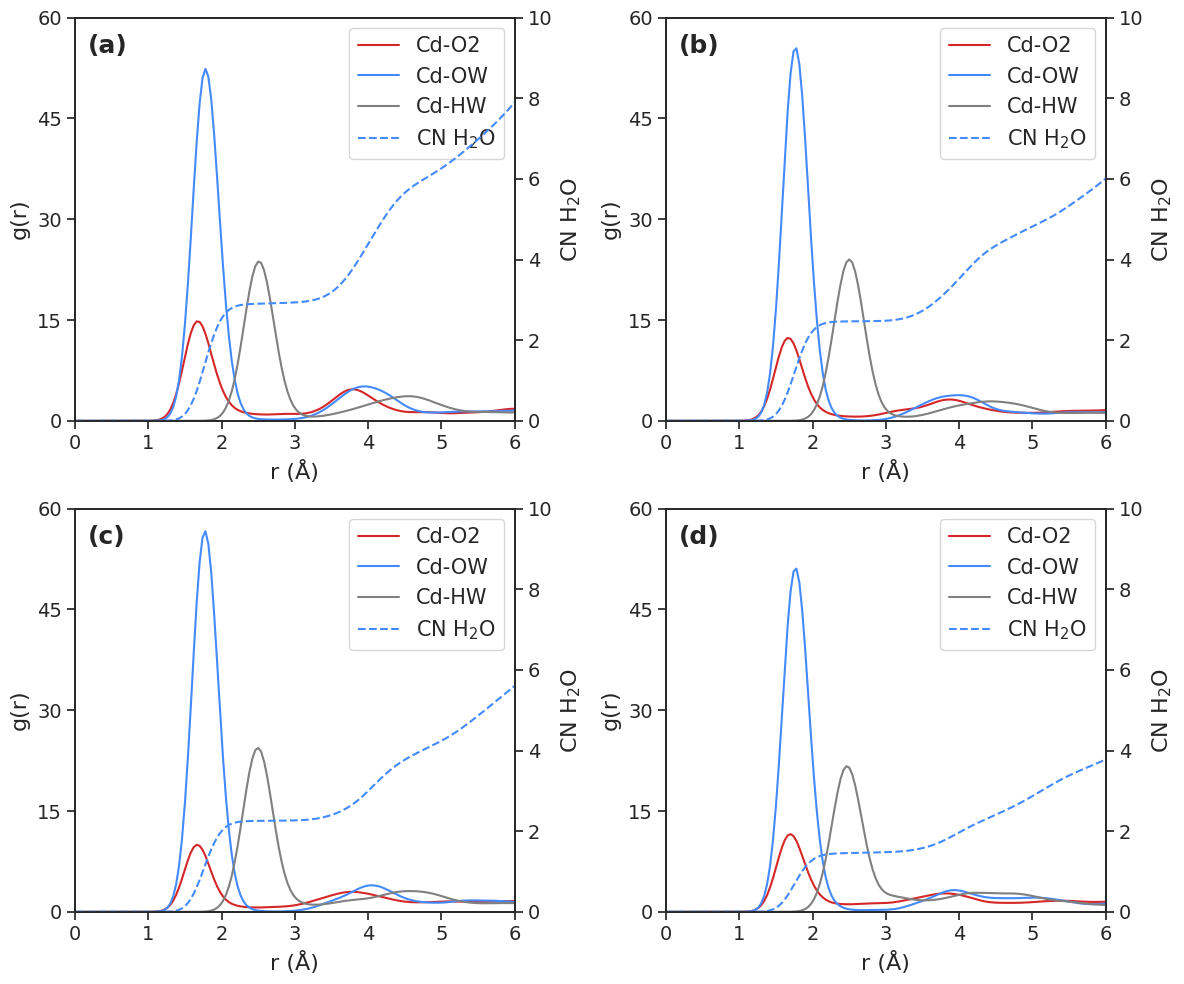

Total execution time: 0.72 seconds


In [2]:
# ============================
# 2️⃣ Radial Distribution Function Water-MOF 
# =========================== 
# 📅 Date Created: Sept 23, 2024

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import glob
import time
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

def read_or_process_rdf_data(cd_value):
    start_time = time.time()
    cache_dir = f'cache_cd{cd_value}'
    os.makedirs(cache_dir, exist_ok=True)
    
    files = glob.glob(f'cd{cd_value}_uio66-COO*_merged_rep_rdf-box.txt')
    dfs = {}
    
    for file in files:
        base_name = os.path.basename(file)
        csv_file = os.path.join(cache_dir, f'{base_name}_last_frame.csv')
        
        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file)
            dfs[base_name] = df
            print(f"Read cached data for {base_name}")
        else:
            print(f"Processing {base_name}")
            with open(file, 'r') as f:
                lines = f.readlines()
            data = []
            frame_title = None
            num_bins = None
            last_frame_data = []
            for line in lines:
                if line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) == 2:
                    if last_frame_data:
                        data = last_frame_data
                    last_frame_data = []
                    frame_title = int(parts[0])
                    num_bins = int(parts[1])
                else:
                    bin_number = int(parts[0])
                    values = list(map(float, parts[1:]))
                    last_frame_data.append([frame_title, bin_number] + values)
            
            data = last_frame_data
            
            if 'COO4' in file:
                columns = ['Frame Title', 'Bin Number'] + [f'c_boxrdf[{i}]' for i in range(1, 16)]
            else:
                columns = ['Frame Title', 'Bin Number'] + [f'c_boxrdf[{i}]' for i in range(1, 18)]
            
            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file, index=False)
            dfs[base_name] = df
    
    end_time = time.time()
    print(f"Total time for data processing/loading: {end_time - start_time:.2f} seconds")
    return dfs

def plot_rdf_subplots(cd_value, sigma=4, png_name='file.png', output_dir='.', x_settings=None, y_settings_left=None, y_settings_right=None):
    start_time = time.time()
    dfs = read_or_process_rdf_data(cd_value)
    
    ordered_keys = sorted(dfs.keys(), key=lambda x: (
        'COO4' in x, 'COO3' in x, 'COO2' in x, 'COO_' in x
    ))
    
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    
    for i, file in enumerate(ordered_keys):
        df = dfs[file]
        
        if 'COO4' in file:
            custom_palette = ["#d62728", "#448AFF", "gray", "#448AFF"]
            columns = ['c_boxrdf[6]','c_boxrdf[12]','c_boxrdf[14]','c_boxrdf[13]']
            legend_names = {
                'c_boxrdf[6]': 'Cd-O2',
                'c_boxrdf[12]': 'Cd-OW',
                'c_boxrdf[14]': 'Cd-HW',
                'c_boxrdf[13]': 'CN H$_2$O'
            }
            cn_h2o_column = 'c_boxrdf[13]'
        else:
            custom_palette = ["#d62728", "#448AFF", "gray", "#448AFF"]
            columns = ['c_boxrdf[6]', 'c_boxrdf[14]','c_boxrdf[16]','c_boxrdf[15]']
            legend_names = {
                'c_boxrdf[6]': 'Cd-O2',
                'c_boxrdf[14]': 'Cd-OW',
                'c_boxrdf[16]': 'Cd-HW',
                'c_boxrdf[15]': 'CN H$_2$O'
            }
            cn_h2o_column = 'c_boxrdf[15]'
        
        handles_left = []
        labels_left = []
        handles_right = []
        labels_right = []
        
        for j, col in enumerate(columns):
            smoothed_values = gaussian_filter1d(df[col], sigma=sigma)
            if col == cn_h2o_column:
                # Plot CN H2O as dashed line and create secondary y-axis for it
                ax2 = axes[i].twinx()
                ax2.set_ylim(y_settings_right['y_min'], y_settings_right['y_max'])
                ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
                ax2.set_yticks(y_settings_right['yticks'])
                line2, = ax2.plot(df['c_boxrdf[1]'], smoothed_values, '--', label=legend_names.get(col, col), color=custom_palette[j])
                ax2.set_ylabel('CN H$_2$O', fontsize=y_settings_right['ylabel_fontsize'], labelpad=y_settings_right['labelpad'])
                ax2.set_yticklabels(ax2.get_yticks(), size=y_settings_right['yticks_fontsize'])
                handles_right.append(line2)
                labels_right.append(legend_names.get(col, col))
            else:
                line1, = axes[i].plot(df['c_boxrdf[1]'], smoothed_values, label=legend_names.get(col, col), color=custom_palette[j])
                handles_left.append(line1)
                labels_left.append(legend_names.get(col, col))
        
        merged_handles = handles_left + handles_right
        merged_labels = labels_left + labels_right
        axes[i].legend(merged_handles, merged_labels, loc='upper right', fontsize=15)
    
        axes[i].text(0.03, 0.96, subplot_labels[i], transform=axes[i].transAxes, 
                     fontsize=18, fontweight='bold', va='top', ha='left')
        axes[i].set_ylabel('g(r)', fontsize=y_settings_left['ylabel_fontsize'], labelpad=y_settings_left['labelpad'])
        axes[i].set_xlabel('r (Å)', fontsize=x_settings['xlabel_fontsize'], labelpad=x_settings['labelpad'])
        axes[i].set_xlim(x_settings['x_min'], x_settings['x_max'])
        axes[i].set_ylim(y_settings_left['y_min'], y_settings_left['y_max'])
        axes[i].set_yticks(y_settings_left['yticks'])
        axes[i].set_yticklabels(axes[i].get_yticks(), size=y_settings_left['yticks_fontsize'])
        axes[i].set_xticks(x_settings['xticks'])
        axes[i].set_xticklabels(axes[i].get_xticks(), size=x_settings['xticks_fontsize'])
        axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
    
    plt.tight_layout()
    plt.show()

    # Save figure to the specified directory
    fig.savefig(os.path.join(output_dir, png_name))
    
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


# Call Script
x_settings = {
    'x_min': 0, 
    'x_max': 6, 
    'xticks': [0, 1, 2, 3, 4, 5, 6], 
    'labelpad': 5, 
    'xticks_fontsize': 14, 
    'xlabel_fontsize': 16
}
y_settings_left = {
    'y_min': 0, 
    'y_max': 60, 
    'yticks': [0, 15, 30, 45, 60], 
    'labelpad': 5, 
    'yticks_fontsize': 14, 
    'ylabel_fontsize': 16
}
y_settings_right = {
    'y_min': 0, 
    'y_max': 10, 
    'yticks': [0, 2, 4, 6, 8, 10], 
    'labelpad': 5, 
    'yticks_fontsize': 14, 
    'ylabel_fontsize': 16
}

output_directory = '/home/josephzc/21Sept2024_data/0_fig/'
plot_rdf_subplots(
    cd_value=100, 
    sigma=4, 
    png_name='rdf_subplots_cd100.png', 
    output_dir=output_directory, 
    x_settings=x_settings, 
    y_settings_left=y_settings_left, 
    y_settings_right=y_settings_right
)
